In [1]:
import torch
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from sklearn.cluster import KMeans

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_data = datasets.MNIST('', train=True, download=True, transform=transform)
test_data = datasets.MNIST('', train=False, download=True, transform=transform)

0.1%

100.1%

Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw
Using downloaded and verified file: MNIST/raw/train-labels-idx1-ubyte.gz
Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw
Using downloaded and verified file: MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw
Using downloaded and verified file: MNIST/raw/t10k-labels-idx1-ubyte.gz
Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw
Processing...
Done!


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=10, shuffle=True)

In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(32 * 32 * 9, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
        

In [5]:
net = Net()
print(net)
X = torch.rand(1, 1, 28, 28)
output = net(X)
print(output)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
tensor([[-2.2571, -2.4055, -2.2130, -2.2492, -2.2451, -2.4389, -2.3739, -2.2383,
         -2.3524, -2.2811]], grad_fn=<LogSoftmaxBackward>)


In [6]:
optimizer = optim.Adam(net.parameters(), lr=1e-3)
criterion = F.nll_loss

EPOCHS = 5

net.train()
for epoch in range(EPOCHS):
    print(f'(Epoch {epoch + 1}/{EPOCHS}) ', end='')
    for X, y in train_loader:
        optimizer.zero_grad()
        output = net(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
    print(f'Loss: {loss}')

(Epoch 1/5) Loss: 0.49355006217956543
(Epoch 2/5) Loss: 0.33955618739128113
(Epoch 3/5) Loss: 0.0015818930696696043
(Epoch 4/5) Loss: 0.024655183777213097
(Epoch 5/5) Loss: 0.00051560637075454


In [31]:
def test():
    net.eval()
    correct = 0

    with torch.no_grad():
        for X, y in test_loader:
            output = net(X)
            prediction = output.argmax(dim=1, keepdim=True)
            correct += (prediction == y.view_as(prediction)).sum().item()

    return correct / len(test_loader.dataset)

print('Accuracy:', test())

Accuracy: 0.9896


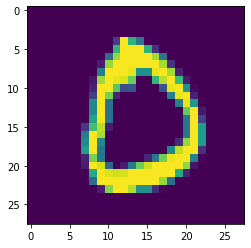

In [32]:
plt.imshow(X[2][0])

In [39]:
print(torch.argmax(net(X)[2]))

tensor(0)


In [51]:
layers_to_update = [net.conv1, net.conv2, net.fc1]

In [52]:
layer_weights = [layer.weight.detach().numpy() for layer in layers_to_update]

In [53]:
def blockshaped(arr, nrows, ncols):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array should look like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """
    # Make convolutional layers two-dimensional
    if len(arr.shape) == 4:
        arr = arr.reshape(arr.shape[0], arr.shape[1] * arr.shape[2] * arr.shape[3])
    return arr.reshape(-1, nrows, ncols)


def undo_blockshaped(blocks, *original_dimensions):
    if len(original_dimensions) == 4:
        blocks = blocks.reshape(original_dimensions[0], original_dimensions[1] * original_dimensions[2] * original_dimensions[3])
    return blocks.reshape(*original_dimensions)

In [54]:
layer_weights[0].shape

(32, 1, 3, 3)

In [56]:
#B is determined by model architecture 
B = 4 
weight_blocks = [blockshaped(weights, B, B) for weights in layer_weights]

In [57]:
all_blocks = np.concatenate(weight_blocks)
all_blocks.shape
all_flat = [block.flatten() for block in all_blocks]

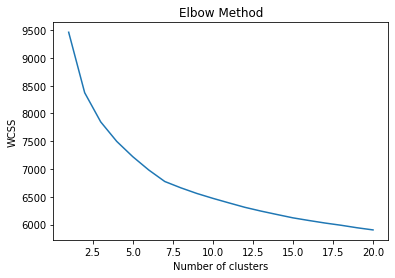

In [58]:
#N determined by architecture (how many legos can be fit)

N = 20
wcss = []
for i in range(1, N + 1):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=500, n_init=N, random_state=0)
    kmeans.fit(all_flat)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, N + 1), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [59]:
def distance(block, center):
    return np.linalg.norm(block - center)

In [60]:
#DELTA is determined by accuracy constraints 
#and architecture (how much is needed for back propagation)
DELTA = abs(.06343089 - 1.923427408)/5
centers = [np.reshape(center, (B, B)) for center in kmeans.cluster_centers_]

lego_set = np.array([
    # First nearby center is good enough, not necessary to find actual closest
    next((center for center in centers if distance(block, center) < DELTA), block)
    for block in all_blocks
], dtype='float32')

k = (all_blocks != lego_set).reshape(-1, B * B).all(axis=1).sum()

print(k / len(lego_set))

0.7556810595743545


In [61]:
# for reconstruction, save metadata about blocks location when creating it
# and use that in above code to modify the layers directly

In [62]:
legos_used = 0

for i, layer in enumerate(layers_to_update):
    n_legos = len(weight_blocks[i])
    layer_legos = lego_set[legos_used:legos_used + n_legos]
    legos_used += n_legos
    updated_weight = undo_blockshaped(layer_legos, *layer.weight.shape)
    layer.weight.data = torch.as_tensor(updated_weight).float()

In [63]:
new_blocks = np.concatenate([blockshaped(layer.weight.detach().numpy(), B, B) for layer in layers_to_update])
print((new_blocks == lego_set).all())

for old_block, new_block in zip(all_blocks, new_blocks):
    assert distance(old_block, new_block) < DELTA

True


In [64]:
test()

0.9897

In [65]:
#see if this is solving the memory overhead is an issue 